In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
warnings.filterwarnings("ignore")


rs = 34
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table of contents

1. [Basic EDA](#eda)
2. [Data preprocessing](#preprocessing)
3. [PCA](#pca)
4. [Modelling](#modelling)
5. [Conclusion](#conclusion)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana;">
    ⚡ If you found a mistake or have any remarks, I'd be grateful for pointing it out in comments ⚡
</div>

# Basic EDA <a id="eda"></a>

Let's get to know the data:

In [2]:
data = pd.read_csv(path)
data.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


Our target feature:

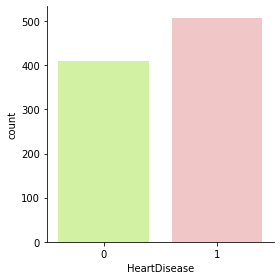

In [3]:
a = sns.catplot(data=data, x="HeartDisease", kind="count", palette={0:"greenyellow", 1: "lightcoral"}, alpha=.5,  height=4)

## Categorical features vs Target

Let's see, if there are any obvious relations between the categorical features and target:



Sex

HeartDisease         0         1
Sex                             
F             0.740933  0.259067
M             0.368276  0.631724


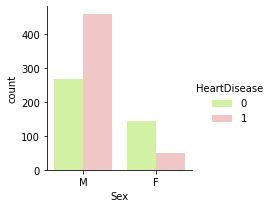



ChestPainType

HeartDisease          0         1
ChestPainType                    
ASY            0.209677  0.790323
ATA            0.861272  0.138728
NAP            0.645320  0.354680
TA             0.565217  0.434783


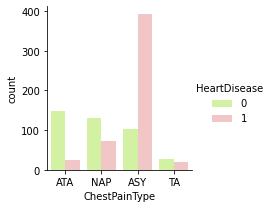



FastingBS

HeartDisease         0         1
FastingBS                       
0             0.519886  0.480114
1             0.205607  0.794393


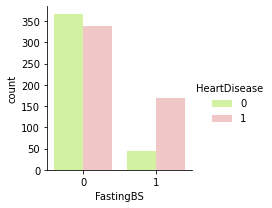



RestingECG

HeartDisease         0         1
RestingECG                      
LVH           0.436170  0.563830
Normal        0.483696  0.516304
ST            0.342697  0.657303


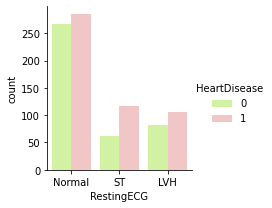



ExerciseAngina

HeartDisease           0         1
ExerciseAngina                    
N               0.648995  0.351005
Y               0.148248  0.851752


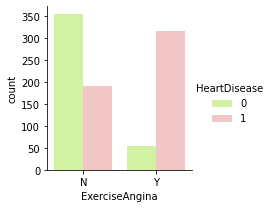



ST_Slope

HeartDisease         0         1
ST_Slope                        
Down          0.222222  0.777778
Flat          0.171739  0.828261
Up            0.802532  0.197468


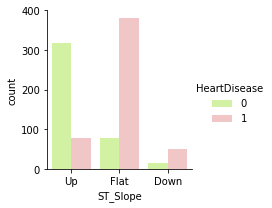

In [4]:

cat = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
fig, ax = plt.subplots()
for f in cat:
    print('\n\n\033[1m' + f + '\033[0m\n')
    print(pd.crosstab(data[f], data.HeartDisease, normalize='index'))
    plt.close(1)
    sns.catplot(x=f, hue='HeartDisease', data=data, kind='count', palette={0:"greenyellow", 1: "lightcoral"}, alpha=.5, height=3)
    ax.set_xlabel(f)
    plt.show()
    


insights:

1. The probability of being diagnosed with a heart disease is higher for males.
2. People who haven't suffered any chest pain can have a heart disease, so this feature gives us not much information about the target
3. People with increased blood sugar (fasting) have increased risk to have a heart disease.
4. People with exercise induced angina have a risk being diagnosed with a heart desease.
5. Healthy people have a slight upsloping ST segment, flat or downsloping ST segment signals an abnormality.

## Numerical features vs Target




Age

count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


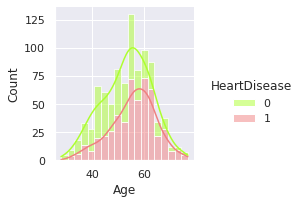



RestingBP

count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64


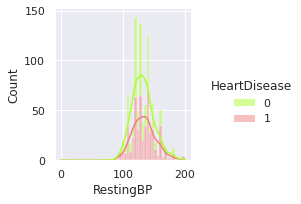



Cholesterol

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64


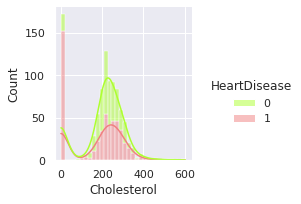



MaxHR

count    918.000000
mean     136.809368
std       25.460334
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64


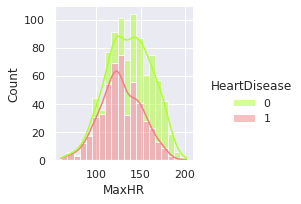



Oldpeak

count    918.000000
mean       0.887364
std        1.066570
min       -2.600000
25%        0.000000
50%        0.600000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64


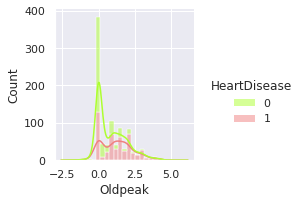

In [5]:
sns.set_theme()
numerical = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
for f in numerical:
    print('\n\n\033[1m' + f + '\033[0m\n')
    print(data[f].describe())
    sns.displot(data, x=f, hue="HeartDisease", palette={0:"greenyellow", 1: "lightcoral"}, alpha=.5, multiple="stack", kde=True, fill=True, height=3)
    plt.show()

insights:
1. Oldpeak = 0 signals no abnormality
2. Holesterol can't be equal to 0 - so these are missing values.



# Data Preprocessing <a id="preprocessing"></a>

1. Outliers 
2. train-test split
2. Categorical variables encoding
3. Standardization
4. Cholesterol - missing values imputation
5. Power Transformation

Outliers

In [6]:
print("Outliers detected: \n")
for col in numerical:
    col_zscore = col + "_zscore"
    data[col_zscore] = (data[col] - data[col].mean())/data[col].std(ddof=0)
    data[col + "_outlier"] = (abs(data[col+"_zscore"])>3).astype(int)
    print(col + ": " + str(data[data[col + "_outlier"] == 1].shape[0]))
    data_drop = data[(data[col + "_outlier"]==1)]
    data = pd.concat([data, data_drop]).drop_duplicates(keep=False)   
    data.drop(col_zscore, axis=1, inplace=True)
    data.drop(col + "_outlier", axis=1, inplace=True)

Outliers detected: 

Age: 0
RestingBP: 8
Cholesterol: 3
MaxHR: 1
Oldpeak: 7


In [7]:
X = data.drop("HeartDisease", axis=1)
y = data.HeartDisease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# encoding
to_encode_cat = ["ChestPainType", "RestingECG", "ST_Slope"]
to_encode_dich = ["Sex", "ExerciseAngina"]

for col in to_encode_dich:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    
onehot = OneHotEncoder(handle_unknown='ignore')
onehot.fit(X_train[to_encode_cat])
names = []
for i in range(len(onehot.categories_)):
    names.extend([to_encode_cat[i] + x for x in onehot.categories_[i]])
x = onehot.transform(X_train[to_encode_cat])
X_train.drop(X_train[to_encode_cat], axis=1, inplace=True)
X_train[names] = pd.DataFrame.sparse.from_spmatrix(x, columns=names, index=X_train.index)
x1 = onehot.transform(X_test[to_encode_cat])
X_test.drop(X_test[to_encode_cat], axis=1, inplace=True)
X_test[names] = pd.DataFrame.sparse.from_spmatrix(x1, columns=names, index=X_test.index)

In [8]:
sc = StandardScaler()
train_transformed = sc.fit_transform(X_train[numerical])
X_train[numerical] = pd.DataFrame(train_transformed,columns = X_train[numerical].columns, index=X_train[numerical].index)
X_test[numerical] = pd.DataFrame(sc.transform(X_test[numerical]),columns = X_test[numerical].columns, index=X_test[numerical].index)

In [9]:
X_train["Cholesterol"][X_train["Cholesterol"]== 0] = np.nan
imputer = KNNImputer()
chol_filled = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train = chol_filled

chol_filled_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test = chol_filled_test



Age



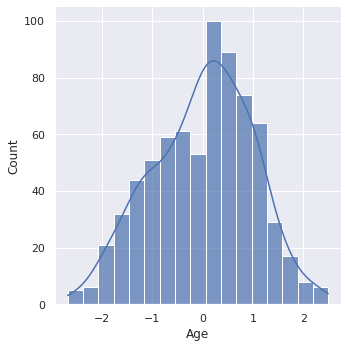



RestingBP



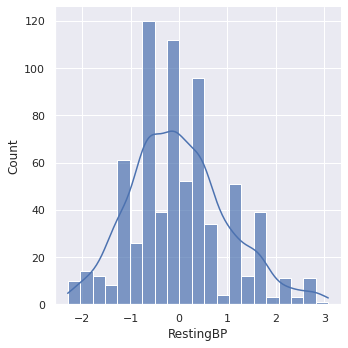



Cholesterol



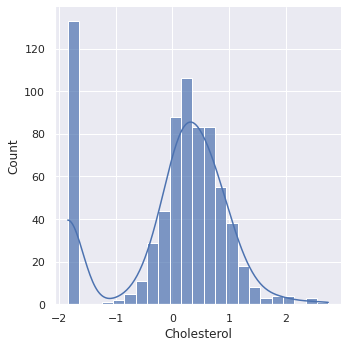



MaxHR



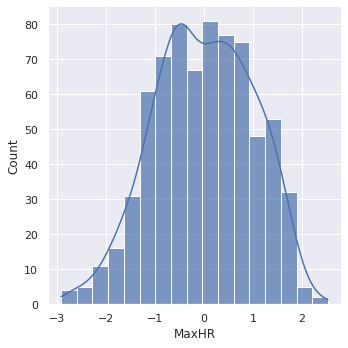



Oldpeak



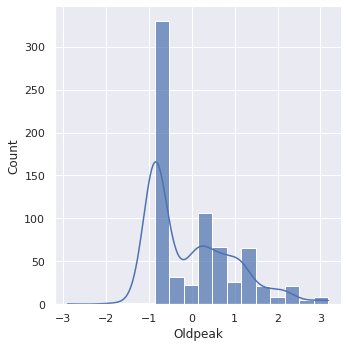

In [10]:
numerical = ["Age","RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
# power transform the raw data
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = pd.DataFrame(power.fit_transform(data[numerical]))
data[numerical] = data_trans
for f in numerical:
    print('\n\n\033[1m' + f + '\033[0m\n')
    sns.displot(X_train, x=f, palette={0:"greenyellow", 1: "lightcoral"}, alpha=.7, kde=True)
    plt.show()

# Feature Selection <a id="pca"></a>

Now we have 18 features. Let's see how informative they are. We will use principal component analysis, the algorithm based on covariance matrix generate new features, that are orthogonal to each other hence linear independent.

<AxesSubplot:>

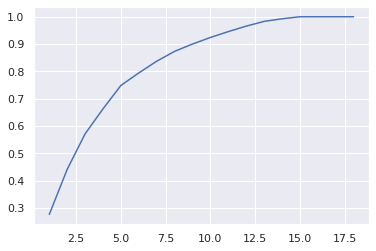

In [11]:
pca = PCA(n_components=18)
pca.fit(X_train)
X_pca = pca.transform(X_train)
var = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(range(1,19), var)

As you can see, we can drop 3 components without any information loss. The thumb rule is to pick the components that explain 95% of variance. In our case, it would be 11 components.

In [12]:
pca = PCA(n_components=11)
pca.fit(X_train)
X_pca = pd.DataFrame(pca.transform(X_train), index=X_train.index)
X_test_pca =  pd.DataFrame(pca.transform(X_test), index=X_test.index)

# Modelling <a id="modelling"></a>

We'll build a basic feed-forward neural net and see how it performs on the dataset.

In [13]:
# creating validation set
x_val = X_pca[-140:]
y_val = y_train[-140:]

X_pca = X_pca[:-140]
y_train = y_train[:-140]

In [14]:
# model architecture
model = Sequential()

model.add(Dense(11, input_shape=[11], activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2

2022-06-04 16:54:00.246099: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
# to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(X_pca, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=400, callbacks=[early_stopping],
    verbose=0)

2022-06-04 16:54:00.561731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Let's see what we got

Best Validation Loss: 0.3130
Best Validation AUC: 0.9326


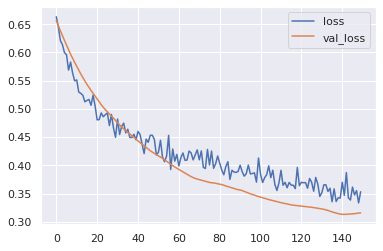

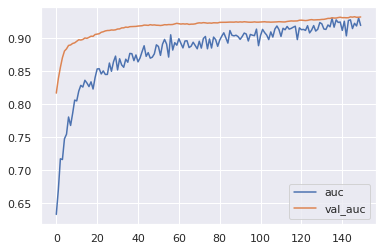

In [16]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation AUC: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_auc'].max()))

In [17]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics 
def info_classification(name, y_test, y_pred, y_pred_proba=None):
    if y_pred_proba.all() != None:
        fpr_log, tpr_log, thresholds_log = metrics.roc_curve(y_test, y_pred_proba)
        auc_log = metrics.roc_auc_score(y_test, y_pred_proba)
    else: 
        fpr_log, tpr_log, thresholds_log = metrics.roc_curve(y_test, y_pred)
        auc_log = metrics.roc_auc_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    f2 = metrics.fbeta_score(y_test, y_pred, beta=2)
    recall = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    plt.plot(fpr_log, tpr_log, color='m',label=name)
    plt.title("ROC " + name)
    plt.legend(loc=4)
    plt.show()
    print("\n" + name + "\n")
    print("accuracy: " + str(metrics.accuracy_score(y_test, y_pred)))
    print("AUC: " + str(auc_log))
    print("recall: " + str(recall))
    print("precision: " + str(precision))
    print("F1: " + str(f1))
    print("F2: " + str(f2))
    print("confusion matrix: \n" + str(metrics.confusion_matrix(y_test, y_pred)))


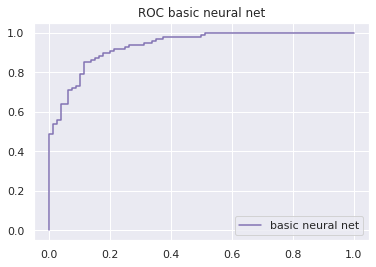


basic neural net

accuracy: 0.8555555555555555
AUC: 0.9359999999999999
recall: 0.9
precision: 0.8490566037735849
F1: 0.8737864077669903
F2: 0.8893280632411067
confusion matrix: 
[[64 16]
 [10 90]]


In [18]:
y_pred_proba = model.predict(X_test_pca)
y_pred = np.round(y_pred_proba).astype(int)
info_classification("basic neural net", y_test, y_pred, y_pred_proba)

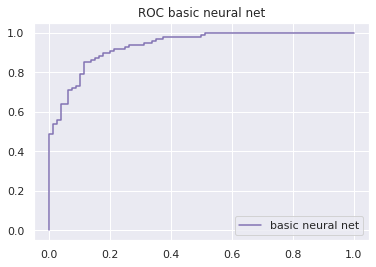


basic neural net

accuracy: 0.8555555555555555
AUC: 0.9359999999999999
recall: 0.9
precision: 0.8490566037735849
F1: 0.8737864077669903
F2: 0.8893280632411067
confusion matrix: 
[[64 16]
 [10 90]]


In [19]:
info_classification("basic neural net", y_test, y_pred, y_pred_proba)

# Conclusion <a id="conclusion"></a>

The model performance on test set is quite good. The high f-score and what is more important (taking in account that it's crucial to identify all positive cases) we've got the good recall and f2 scores. 